# 2
### В тебе є якийсь текст. Виділи в ньому ознаки, які вважаєш за потрібне для того щоб потім (можливо) зробити якісну класифікацію ( feature engineering). 


Ми не розглядаємо завдання класифікації чи кластеризації, це задача на перевірку feature engineering скілів. Але якщо це допоможе у вирішенні, то розглядалась ця задача як задача класифікації. Просто потрібно взяти текст(можна просто знайти щось в інтернеті, це не дуже важливо) і подумати, які фічі та як у ньому виділити. З кодом. (У завданнях було зазначено, якщо код не обов'язковий)

Для відповіді на дане питання я взяла перших 100 рядів з датасету  https://www.kaggle.com/shivamb/extensive-text-data-feature-engineering.

<ol> Аналіз тексту та створення нових функцій (фіч) включає:
<li>Налаштування середовища (імпорт необхідних пакетів та читання даних).</li>
<li>Розпізнавання мови (визнаяення, яка мова основна для даних) </li>
<li>Попередня обробка тексту(підготовка вихідних даних, очищення тексту, перетворення тексту, видалення стоп-слів, стемінг, лематизація)</li>
<li>Аналіз довжини (кількість слів в тексті, символів в тексті, речень, пунктуацій...)</li>
<li>Аналіз настрою (визначення, позитивний чи негативний текст)</li>
<li>Розпізнавання іменованої особи (текст тегу із заздалегідь визначеними категоріями, такими як імена осіб, організації, місцезнаходження)</li>
<li>Векторизація вже обробленого тексту (перетворення в числу форму)</li>


In [1]:
import pandas as pd
import collections
import json

import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud

import re
import nltk

import langdetect

from textblob import TextBlob

import spacy
from sklearn import feature_extraction, manifold
import gensim.downloader as gensim_api
import gensim

import warnings
import string
punctuation = string.punctuation

In [2]:
#pip install wordcloud
#pip install NLTK
#pip install langdetect
#pip install TextBlob
#pip install spacy
#pip install gensim


In [3]:
#читання даних
df = pd.read_csv('Data_Train_kaggle.csv',nrows = 100, encoding='cp1252')
print(df.shape)
df.head()

(100, 2)


,STORY,SECTION
0,But the most painful was the huge reversal in ...,3
1,How formidable is the opposition alliance amon...,0
2,Most Asian currencies were trading lower today...,3
3,"If you want to answer any question, click on ‘...",1
4,"In global markets, gold prices edged up today ...",3


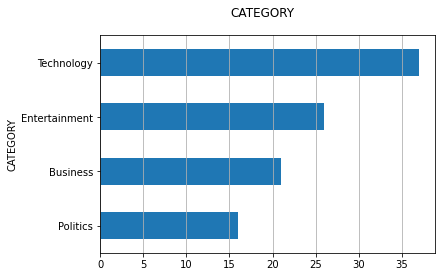

In [4]:
#для зручності розуміння додамо стовпець з назвами категорій(SECTION), який при навчанні моделі видалити:
df['CATEGORY'] = df.SECTION.map({3:'Business',
              0:'Politics',  
              1:'Technology',  
              2:'Entertainment' })
#дані не збалансовані:
fig, ax = plt.subplots()
fig.suptitle('CATEGORY', fontsize=12)
df['CATEGORY'].reset_index().groupby('CATEGORY').count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

In [5]:
%%time
#визначення мови(додавання даної фічі не доцільне, оскільки всі дані подано англійською):
df["STORY"].apply(lambda x: langdetect.detect(x) if 
                                 x.strip() != "" else "").unique()

Wall time: 1.45 s


array(['en'], dtype=object)

In [6]:
#щоб не видалити імена (як стоп-слова), у наборі даних в подальшій обробці їх треба змінити (за допомогою SpaCy):
import en_core_web_sm
ner = en_core_web_sm.load()# tag text

STORY_new = []
for i in df['STORY']:
    entities = ner(i).ents
    tagged_txt = i
    for tag in entities:
        tagged_txt = re.sub(tag.text, "_".join(tag.text.split()), 
                            tagged_txt)
    STORY_new += [tagged_txt]
df['STORY_new_name'] = STORY_new

C:\Users\Admin\anaconda3\lib\site-packages\spacy\util.py:275: UserWarning: [W031] Model 'en_core_web_sm' (2.2.0) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.2). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [7]:
#стоп-слова з англійської мови
lst_stopwords = nltk.corpus.stopwords.words("english")

# очищення тексту(стемінг/лемматизація):
def stemm_lemm_func(text, flg_stemm=False, flg_lemm=True, lst_stopword=None):
    
    #cclean (перетворити в нижній регістр і видалити пунктуації та символи, а потім зняти strip
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())           
    #Токенізувати (перетворити з рядка в список)
    lst_text = text.split()
    #видалити     стоп-слова
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]               
    #стемінг (Stemming- видалення -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]               
    #лемматизація (перетворення слова в кореневе слово)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]           
    #повернутися до рядка зі списку
    text = " ".join(lst_text)
    return text

In [8]:
#тепер можна створювати нові фічі:

def text_feature_count(text):
    
    #застосовувати стемінг / лематизацію(застосовується щось одне) :
    df['TEXT_clean'] = df[text].apply(lambda x: stemm_lemm_func(x,
                                                flg_stemm=False, 
                                                flg_lemm=True, 
                                                lst_stopword=lst_stopwords))
    
    #кількість слів в тексті
    df ['word_count'] = df[text].apply(lambda x: len(str(x).split(" ")))
    
    #кількість символів в тексті
    df ['char_count'] = df[text].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
    
    #кількість речень
    df ['sentence_count'] = df[text].apply(lambda x: len(str(x).split(".")))
    
    #середня довжина слова (кількість символів / кількість слів)
    df ['avg_word_length'] = df['char_count'] / df['word_count']
    
    #середня довжина речення(кількість слів / кількість речень)
    df ['avg_sentence_lenght'] = df['word_count'] / df['sentence_count']
    
    #кількість пунктуацій
    df['punctuation_count'] = df[text].apply(lambda x: len("".join(_ for _ in x if _ in punctuation))) 
    
    #кількість слів прописаних з великої літери
    df['title_word_count'] = df[text].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
    
    #кількість слів тільки верхнього реєстру
    df['upper_case_word_count'] = df[text].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))
    
    #кількість стоп-слів
    df['stopword_count'] = df[text].apply(lambda x: len([wrd for wrd in x.split() if wrd.lower() in lst_stopwords]))

  
    #додати фічу настрою за допомогою Textblob
    df["sentiment"] = df[text].apply(lambda x: 
                       TextBlob(x).sentiment.polarity)

text_feature_count('STORY_new_name')  
df.head ()

,STORY,SECTION,CATEGORY,STORY_new_name,TEXT_clean,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght,punctuation_count,title_word_count,upper_case_word_count,stopword_count,sentiment
0,But the most painful was the huge reversal in ...,3,Business,But the most painful was the huge reversal in ...,painful huge reversal fee income unheard among...,146,698,9,4.780822,16.222222,12,10,0,66,0.226923
1,How formidable is the opposition alliance amon...,0,Politics,How formidable is the opposition alliance amon...,formidable opposition alliance among congress ...,13,117,1,9.000000,13.000000,10,5,1,4,0.000000
2,Most Asian currencies were trading lower today...,3,Business,Most Asian currencies were trading lower today...,asian currency trading lower today south_korea...,56,331,15,5.910714,3.733333,32,12,1,17,0.012103
3,"If you want to answer any question, click on ‘...",1,Technology,"If you want to answer any question, click on ‘...",want answer question click answer clicking ans...,98,490,9,5.000000,10.888889,15,12,0,51,0.058333
4,"In global markets, gold prices edged up today ...",3,Business,"In global markets, gold prices edged up today ...",global market gold price edged today disappoin...,46,254,5,5.521739,9.200000,10,5,0,9,-0.015556


In [9]:
#за допомогою NER (Named-entity recognition) провести підрахунок категорій сутностей 
#(імена осіб, організації, місцезнаходження, вирази часу, кількості...)

#додайте текст тегу та вилучіть теги до списку
df['tags'] = df['STORY_new_name'].apply(lambda x: [(tag.text, tag.label_) 
                                for tag in ner(x).ents] )
# utils function  для підрахунку елемента списку
def utils_lst_count(lst):
    dic_counter = collections.Counter()
    for x in lst:
        dic_counter[x] += 1
    dic_counter = collections.OrderedDict( 
                     sorted(dic_counter.items(), 
                     key=lambda x: x[1], reverse=True))
    lst_count = [ {key:value} for key,value in dic_counter.items() ]
    return lst_count

# count 
df['tags'] = df['tags'].apply(lambda x: utils_lst_count(x))

# utils function створити новий стовпець для кожної категорії тегів
def utils_ner_features(lst_dics_tuples, tag):
    if len(lst_dics_tuples) > 0:
        tag_type = []
        for dic_tuples in lst_dics_tuples:
            for tuple in dic_tuples:
                type, n = tuple[1], dic_tuples[tuple]
                tag_type = tag_type + [type]*n
                dic_counter = collections.Counter()
                for x in tag_type:
                    dic_counter[x] += 1
        return dic_counter[tag]
    else:
        return 0

# extract features
tags_set = []
for lst in df['tags'].tolist():
     for dic in lst:
            for k in dic.keys():
                tags_set.append(k[1])
tags_set = list(set(tags_set))
for feature in tags_set:
     df['tags_'+feature] = df['tags'].apply(lambda x: 
                             utils_ner_features(x, feature))

## print result
df.head()

,STORY,SECTION,CATEGORY,STORY_new_name,TEXT_clean,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght,...,tags_EVENT,tags_ORG,tags_CARDINAL,tags_MONEY,tags_ORDINAL,tags_QUANTITY,tags_PERCENT,tags_GPE,tags_NORP,tags_FAC
0,But the most painful was the huge reversal in ...,3,Business,But the most painful was the huge reversal in ...,painful huge reversal fee income unheard among...,146,698,9,4.780822,16.222222,...,0,1,0,0,0,0,0,0,0,0
1,How formidable is the opposition alliance amon...,0,Politics,How formidable is the opposition alliance amon...,formidable opposition alliance among congress ...,13,117,1,9.000000,13.000000,...,0,4,0,0,0,0,0,0,0,0
2,Most Asian currencies were trading lower today...,3,Business,Most Asian currencies were trading lower today...,asian currency trading lower today south_korea...,56,331,15,5.910714,3.733333,...,0,0,2,0,0,0,8,4,5,0
3,"If you want to answer any question, click on ‘...",1,Technology,"If you want to answer any question, click on ‘...",want answer question click answer clicking ans...,98,490,9,5.000000,10.888889,...,0,0,0,0,0,0,0,0,1,0
4,"In global markets, gold prices edged up today ...",3,Business,"In global markets, gold prices edged up today ...",global market gold price edged today disappoin...,46,254,5,5.521739,9.200000,...,0,0,0,1,0,0,1,0,3,0


In [10]:
df.columns, len(df.columns)

(Index(['STORY', 'SECTION', 'CATEGORY', 'STORY_new_name', 'TEXT_clean',
        'word_count', 'char_count', 'sentence_count', 'avg_word_length',
        'avg_sentence_lenght', 'punctuation_count', 'title_word_count',
        'upper_case_word_count', 'stopword_count', 'sentiment', 'tags',
        'tags_WORK_OF_ART', 'tags_PRODUCT', 'tags_LOC', 'tags_DATE',
        'tags_TIME', 'tags_PERSON', 'tags_EVENT', 'tags_ORG', 'tags_CARDINAL',
        'tags_MONEY', 'tags_ORDINAL', 'tags_QUANTITY', 'tags_PERCENT',
        'tags_GPE', 'tags_NORP', 'tags_FAC'],
       dtype='object'),
 32)

In [11]:
%%time
#векторзуємо очищений текст:
X_to_vec = df['TEXT_clean']
df = df.drop(['STORY','CATEGORY' ,'STORY_new_name', 'TEXT_clean', 'tags'], axis=1) 
vectorizer = feature_extraction.text.CountVectorizer()
df_X = pd.DataFrame(vectorizer.fit_transform(X_to_vec).todense())
#об'єднуємо фічі створені попередньо та векторизовані
df = pd.concat([df, df_X.set_index(df.index)], axis=1)
y = df['SECTION'].copy()
X_train = df.iloc[:,1:]

Wall time: 60 ms


In [14]:
X_train.info()
X_train

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Columns: 2994 entries, word_count to 2967
dtypes: float64(3), int64(2991)
memory usage: 2.3 MB


,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght,punctuation_count,title_word_count,upper_case_word_count,stopword_count,sentiment,...,2958,2959,2960,2961,2962,2963,2964,2965,2966,2967
0,146,698,9,4.780822,16.222222,12,10,0,66,0.226923,...,0,0,0,0,0,0,0,0,0,0
1,13,117,1,9.000000,13.000000,10,5,1,4,0.000000,...,0,0,0,0,0,0,0,0,0,0
2,56,331,15,5.910714,3.733333,32,12,1,17,0.012103,...,0,0,0,0,0,0,0,0,0,0
3,98,490,9,5.000000,10.888889,15,12,0,51,0.058333,...,0,0,0,0,0,0,0,0,0,0
4,46,254,5,5.521739,9.200000,10,5,0,9,-0.015556,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,51,405,1,7.941176,51.000000,25,18,0,14,0.146465,...,0,0,0,0,0,1,0,0,0,0
96,21,98,1,4.666667,21.000000,1,6,2,8,0.000000,...,0,0,0,0,0,0,0,0,0,0
97,234,1416,12,6.051282,19.500000,70,51,8,95,-0.046717,...,0,0,0,0,0,0,0,0,0,0
98,107,690,1,6.448598,107.000000,16,13,1,44,-0.042857,...,0,0,0,0,0,0,0,0,0,0


Підготовка даних завершена,нові фічі створено, можна приступати до класифікації.